# MobileNet Quick Drew Example - With Pre-Train Model & Transfer Learning
- This notebook show you to load dataset, train mobilenet, test the model and convert to tflite for deployment on nuvoTon target board.
- Please follow the step by step and you could change the parameters for exploring the possibility.  

In [1]:
%matplotlib inline
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"
import os
import sys
import ast
import re
import pathlib
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 14
import seaborn as sns
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, DepthwiseConv2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization, ReLU, GlobalAveragePooling2D 
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
start = dt.datetime.now()

In [2]:
#---------------------------------------------#
# Update parameters basing on your request
#---------------------------------------------#

DP_DIR = './dataset/simplified_small_bitmap_64' # The shuffled dataset
TIME_COLOR = False

NUM_CATS = 5                                # The classes number

WORK_DIR = './workspace/5_mobilenetv1_025_tf_ep'      # The user defined name of work dir
MODEL_NAME = 'mobilenetv1_025_5'                        # The output model's name

INPUT_IMG_SIZE = 64                               # The size of training input image
BATCHSIZE = 512                                   # For train data generator's batchsize => train data number every 1 epoch = STEPS_P_EPOCH * BATCHSIZE

EPOCHS = 10                                      # How many EPOCHS for 1 training.

MODEL_TYPE = 'mobilenetv1'                    # 'mobilenetv1', 'mobilenetv2', 'mobilenetv3'
ALPHA_WIDTH = 1              

PRETRAIN_DIR = './pretrain_model/mobilenetv1_100_335/'
#---------------------------------------------#

np.random.seed(seed=1987)
#tf.set_random_seed(seed=1987)
def f2cat(filename: str) -> str:
    return filename.split('.')[0]

def create_dirs(proj_path, model_name): 
    if not os.path.exists(proj_path):
        os.makedirs(proj_path)
        os.makedirs(os.path.join(proj_path, model_name))
        os.makedirs(os.path.join(proj_path, 'tflite'))
        os.makedirs(os.path.join(proj_path, 'checkpoint'))
        os.makedirs(os.path.join(proj_path, 'opt'))
    else:
        print('Work folder exist!')    
    return proj_path

create_dirs(WORK_DIR, MODEL_NAME)    

'./workspace/5_mobilenetv1_025_tf_ep'

## 1. Create Image Generator for training and the validation dataset

In [3]:

train_dataset = tf.keras.utils.image_dataset_from_directory(os.path.join(DP_DIR, 'train'),
                                                            label_mode='categorical', 
                                                            shuffle=True,
                                                            color_mode = 'grayscale',
                                                            batch_size=BATCHSIZE,
                                                            image_size=(INPUT_IMG_SIZE, INPUT_IMG_SIZE))
validation_dataset = tf.keras.utils.image_dataset_from_directory(os.path.join(DP_DIR, 'validation'),
                                                                 label_mode='categorical',
                                                                 shuffle=True,
                                                                 color_mode = 'grayscale',
                                                                 batch_size=BATCHSIZE,
                                                                 image_size=(INPUT_IMG_SIZE, INPUT_IMG_SIZE))

class_names = train_dataset.class_names
print('Class names: {}'.format(class_names))
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))

Found 400000 files belonging to 5 classes.
Found 50000 files belonging to 5 classes.
Class names: ['airplane', 'alarm clock', 'ambulance', 'angel', 'animal migration']
Number of train batches: 782
Number of validation batches: 98


In [4]:
#@tf.autograph.experimental.do_not_convert
#@tf.function
def normalization_data( dataset):
    
    #if not TIME_COLOR:
    #    def no_time_color(x,y): 
    #        return tf.cond((x!=0), lambda: 255, lambda: 255) 
    #    out_dataset = dataset.map(lambda x, y: ((255 if x!=0. else 0), y), num_parallel_calls=tf.data.AUTOTUNE) # Change back to color 255 only

    # normalization for the data, expects pixel values in [0, 1] from [0, 255]
    #normalization_layer =  tf.keras.layers.Rescaling(1./127.5, offset=-1)
    normalization_layer =  tf.keras.layers.Rescaling(1./255.)      
    out_dataset = dataset.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)

    return out_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

train_dataset = normalization_data(train_dataset)
validation_dataset = normalization_data(validation_dataset)

train dataset example:


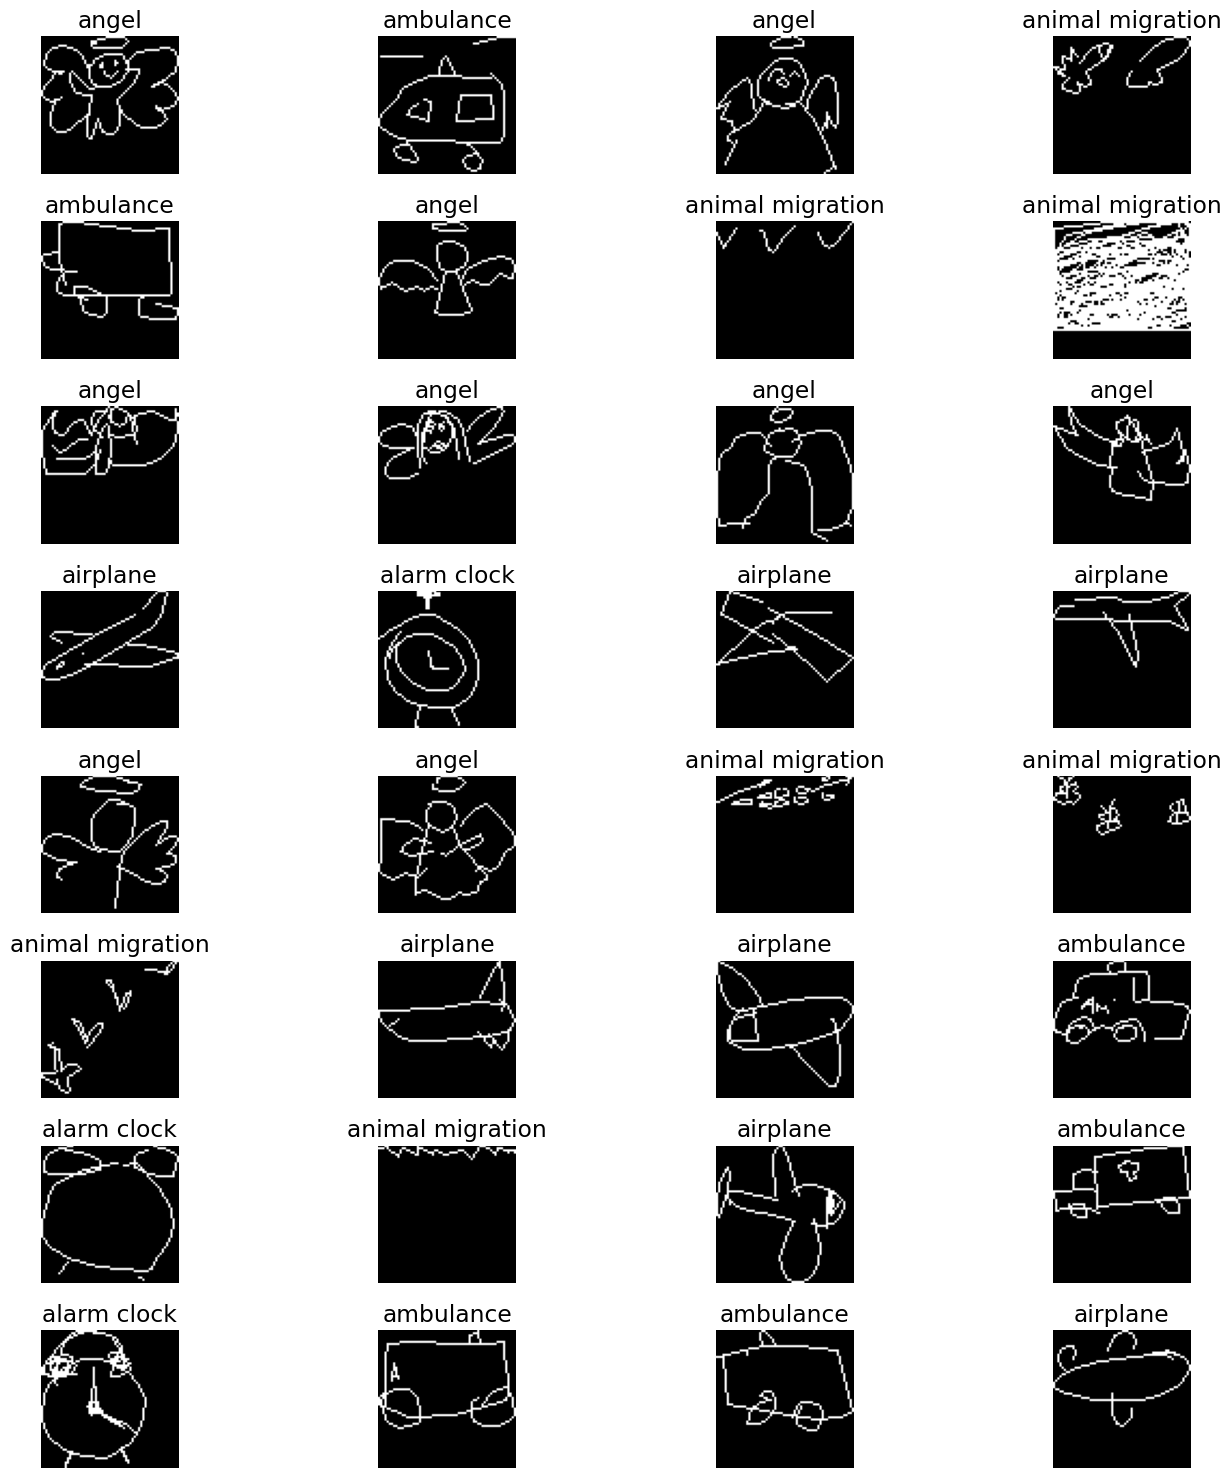

In [5]:
print("train dataset example:")
for images, labels in validation_dataset.take(1):
  plt.figure(figsize=(15, 15))
  x = 0
  for im, l in zip(images, labels):
    if x > 31:
          break   
    ax = plt.subplot(8, 4, x + 1)
    x = x +1
    #print(im)
    plt.imshow(im.numpy().astype("int8"), cmap=plt.cm.gray)
    plt.title(class_names[tf.math.argmax(l)])
    plt.axis("off")
  plt.tight_layout()
  plt.show();   

## 2. Start to train

- #### Load pre-train model, replace the classification head and use transfer learning.

In [6]:
def load_pretrain_model(md_path):
    # load the keras model and the custom op.
    base_model = keras.models.load_model(md_path, custom_objects={'top_3_accuracy':top_3_accuracy}, compile=False)
    base_model.trainable = False

    print("The total layers number: {}".format(len(base_model.layers)))

    # create the custom model
    #inputs = tf.keras.Input(shape=(INPUT_IMG_SIZE, INPUT_IMG_SIZE, 1))
  
    # remove the last classification head
    x = base_model.layers[-4].output
   
    #yy = base_model.get_layer("mobilenet_0.25_64")
    #print(len(yy.layers))
    #print(yy.layers[85])

    # add the new classification head
    #x = tf.keras.layers.GlobalAveragePooling2D(keepdims=True)(x)
    #x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Conv2D(NUM_CATS, (1, 1), padding="same")(x)
    x = tf.reshape(x,[-1, NUM_CATS])
    predictions = tf.keras.layers.Softmax()(x)
    #predictions = Dense(NUM_CATS, activation='softmax',  name='add_dense_1')(x)
    model = tf.keras.Model(base_model.input, predictions)

    return model

def find_best_ckpt(dir_path, model):
      pattern = re.compile(r"\d.\d+")
      max_number = None
      # Iterate over the files in the directory
      for file in dir_path.iterdir():
          filename = file.name
          match = pattern.search(filename)
          if match:
              number_str = match.group()
              number = float(number_str)
              if max_number is None or number > max_number:
                  max_number = number
      if max_number is None:
          print("There is no best ckpt in this work project.")  
      else:
          print("Find the best ckpt:{}".format(pathlib.Path(dir_path)/(number_str+f'_best_val.ckpt')))
          model.load_weights(str(pathlib.Path(dir_path)/(number_str+f'_best_val.ckpt')))   

          #load = tf.keras.models.load_model(dir_path, compile ="False")
          #model.set_weights(load.get_weights())   
      
      return model

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [7]:
if MODEL_TYPE.lower() == 'mobilenetv1':

    model = load_pretrain_model(PRETRAIN_DIR)
     
# If there is a checkpt, load the previous weights.
if (pathlib.Path(WORK_DIR)/'checkpoint').exists():    
    print("Previous checkpoint folder found; loading saved weights")
    model = find_best_ckpt((pathlib.Path(WORK_DIR)/'checkpoint'), model)
else:
    print("No checkpoint found, create the workfolder.")    

print("The trainable layers number: {}".format(len(model.trainable_variables)))
print(model.summary())

# Compile the model
if MODEL_TYPE.lower() == 'mobilenetv1':
    model.compile(optimizer=Adam(learning_rate=0.002), loss='categorical_crossentropy',
              metrics=[categorical_crossentropy, categorical_accuracy, top_3_accuracy])
    

The total layers number: 7
Previous checkpoint folder found; loading saved weights
There is no best ckpt in this work project.
The trainable layers number: 2
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 mobilenet_1.00_64 (Function  (None, 2, 2, 1024)       3228288   
 al)                                                             
                                                                 
 global_average_pooling2d (G  (None, 1, 1, 1024)       0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1, 1, 1024)        0         
                                                                 
 conv2d (Conv2D)             (None,

- #### Training section
- This part is transfer learning training, and it takes 10mins (Nvdia RTX-3090 training from scratch) to get a decent result.
- The actual training time is basing on your hardware, usage size of training dataset and model scale.


In [38]:

callbacks_chpt = tf.keras.callbacks.ModelCheckpoint(
                filepath=(os.path.join(WORK_DIR, 'checkpoint', '{val_categorical_accuracy:.3f}_best_val.ckpt')),
                save_weights_only=True, 
                monitor='val_categorical_accuracy',
                mode = 'max',
                save_best_only=True, 
                save_freq='epoch')

callbacks = [
    EarlyStopping(monitor='val_categorical_accuracy', patience=15, min_delta=0.001, mode='max'),
    ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=5, min_delta=0.005, mode='max', cooldown=3),
    callbacks_chpt
]

hists = []
hist = model.fit(
    train_dataset, epochs=EPOCHS, verbose=1,
    validation_data=validation_dataset,
    callbacks = callbacks
)
hists.append(hist)

Epoch 1/5
782/782 [==============================] - 64s 79ms/step - loss: 0.7924 - categorical_crossentropy: 0.7924 - categorical_accuracy: 0.7231 - top_3_accuracy: 0.9459 - val_loss: 0.6900 - val_categorical_crossentropy: 0.6900 - val_categorical_accuracy: 0.7754 - val_top_3_accuracy: 0.9560 - lr: 0.0020
Epoch 2/5
782/782 [==============================] - 57s 73ms/step - loss: 0.7907 - categorical_crossentropy: 0.7907 - categorical_accuracy: 0.7238 - top_3_accuracy: 0.9459 - val_loss: 0.6889 - val_categorical_crossentropy: 0.6889 - val_categorical_accuracy: 0.7765 - val_top_3_accuracy: 0.9558 - lr: 0.0020
Epoch 3/5
782/782 [==============================] - 57s 72ms/step - loss: 0.7902 - categorical_crossentropy: 0.7902 - categorical_accuracy: 0.7247 - top_3_accuracy: 0.9457 - val_loss: 0.6877 - val_categorical_crossentropy: 0.6877 - val_categorical_accuracy: 0.7764 - val_top_3_accuracy: 0.9560 - lr: 0.0020
Epoch 4/5
782/782 [==============================] - 57s 73ms/step - loss: 0

- #### Fine tune the transfer learning model by setting some layers as trainable

In [53]:
def unwrap_model_set_trainable(unwrap_model, fine_tune_layers_at, base_model_trainable_EN=True):

    print("The original layers number: {}".format(len(unwrap_model.layers)))
    print("The original trainable layers number: {}".format(len(unwrap_model.trainable_variables)))

    mn_name = unwrap_model.layers[1].name # need the name of base model to get the intermediate layers
    print("The name of unwraping pretrain base model: {}".format(mn_name))
    base_model = unwrap_model.get_layer(mn_name)
    print("The total layers number of base model: {}".format(len(base_model.layers)))
    
    # Freeze all the layers before the `fine_tune_at` layer
    base_model.trainable = base_model_trainable_EN
    if fine_tune_layers_at >= len(base_model.layers):
        print("Warning: The 'fine_tune_layers_at' is larger than siez of base_model layer. There are no new trainable layers for fine-tune!!")
    else:    
        for layer in base_model.layers[:fine_tune_layers_at]:
            layer.trainable = False
    print("The trainable layers number of base model: {}".format(len(base_model.trainable_variables)))

    inp = base_model.input
    out = unwrap_model.get_layer(unwrap_model.layers[2].name)(base_model.output)
    for i in range(3, len(unwrap_model.layers)):    
        if unwrap_model.layers[i].name.count('tf.reshape'): # the model.get_layer('tf.reshape') need other way to insert.
            out = tf.reshape(out,[-1, NUM_CATS])
        else:
            out = unwrap_model.get_layer(unwrap_model.layers[i].name)(out)
    
    return tf.keras.Model(inp, out)   


unwrapped_finetune_model = unwrap_model_set_trainable(model, 60)

unwrapped_finetune_model.summary()
print("The total layers number: {}".format(len(unwrapped_finetune_model.layers)))
print("The trainable layers number: {}".format(len(unwrapped_finetune_model.trainable_variables)))



The original layers number: 7
The original trainable layers number: 2
The name of unwraping pretrain base model: mobilenet_0.25_64
The total layers number of base model: 86
The trainable layers number of base model: 24
The total layers number: 91
The trainable layers number: 26
Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv1 (Conv2D)              (None, 32, 32, 8)         72        
                                                                 
 conv1_bn (BatchNormalizatio  (None, 32, 32, 8)        32        
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 32, 32, 8)         0         
                                           

In [54]:
EPOCHS_FINETUNE = 20
# Compile the model
if MODEL_TYPE.lower() == 'mobilenetv1':
    unwrapped_finetune_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy',
              metrics=[categorical_crossentropy, categorical_accuracy, top_3_accuracy])
callbacks_finetune = [
    EarlyStopping(monitor='val_categorical_accuracy', patience=15, min_delta=0.001, mode='max'),
    ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=5, min_delta=0.005, mode='max', cooldown=3),
]    

In [55]:
hist_finetune = unwrapped_finetune_model.fit(
    train_dataset, epochs=EPOCHS_FINETUNE, verbose=1,
    validation_data=validation_dataset,
    callbacks = callbacks_finetune
)
hists.append(hist_finetune)

Epoch 1/20
782/782 [==============================] - 59s 73ms/step - loss: 1.1137 - categorical_crossentropy: 1.1137 - categorical_accuracy: 0.8395 - top_3_accuracy: 0.9667 - val_loss: 0.3553 - val_categorical_crossentropy: 0.3553 - val_categorical_accuracy: 0.8937 - val_top_3_accuracy: 0.9782 - lr: 0.0010
Epoch 2/20
782/782 [==============================] - 58s 74ms/step - loss: 0.3216 - categorical_crossentropy: 0.3216 - categorical_accuracy: 0.8976 - top_3_accuracy: 0.9803 - val_loss: 0.2762 - val_categorical_crossentropy: 0.2762 - val_categorical_accuracy: 0.9130 - val_top_3_accuracy: 0.9839 - lr: 0.0010
Epoch 3/20
782/782 [==============================] - 58s 74ms/step - loss: 0.2770 - categorical_crossentropy: 0.2770 - categorical_accuracy: 0.9111 - top_3_accuracy: 0.9833 - val_loss: 0.2556 - val_categorical_crossentropy: 0.2556 - val_categorical_accuracy: 0.9181 - val_top_3_accuracy: 0.9848 - lr: 0.0010
Epoch 4/20
782/782 [==============================] - 57s 73ms/step - los

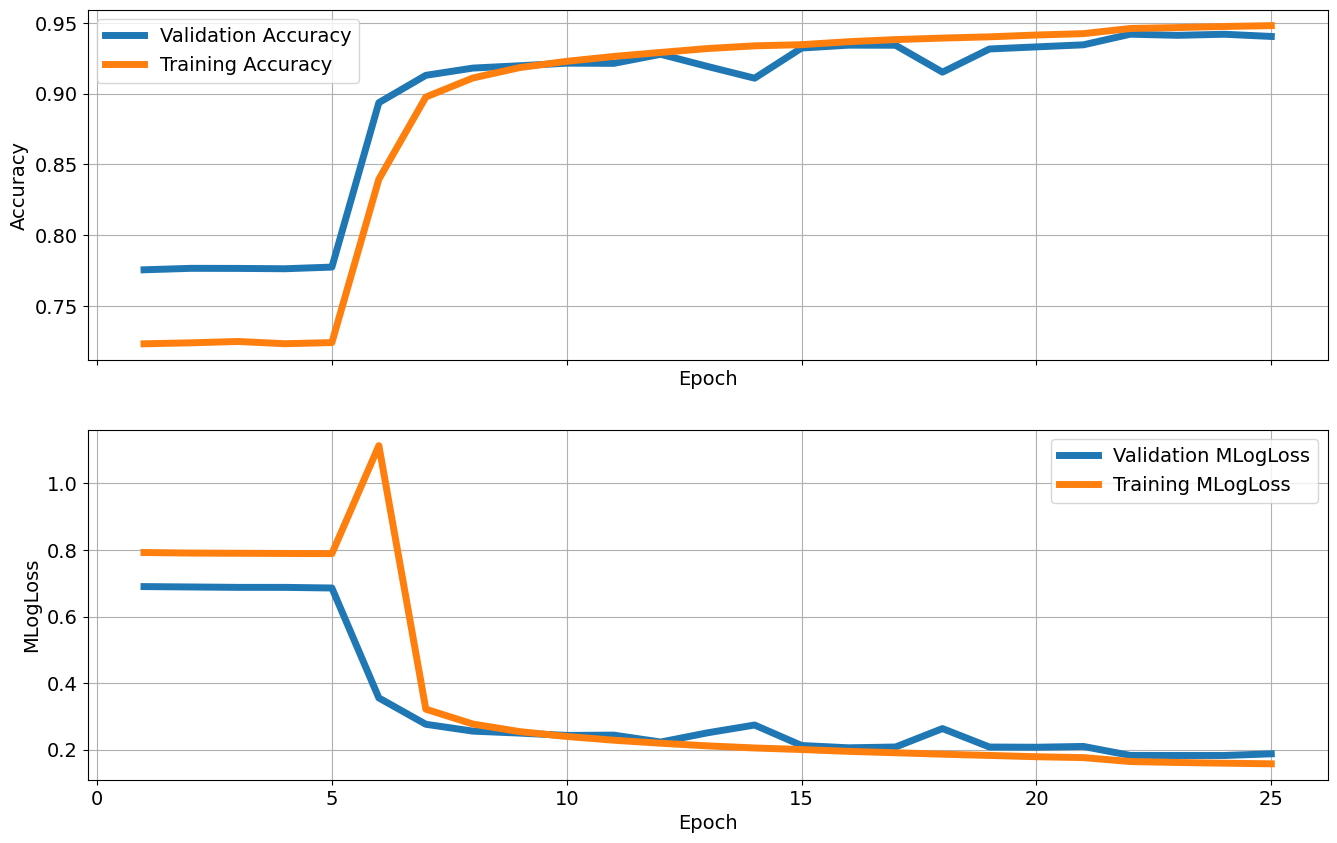

In [56]:
hist_df = pd.concat([pd.DataFrame(hist.history) for hist in hists], sort=True)
hist_df.index = np.arange(1, len(hist_df)+1)
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
axs[0].plot(hist_df.val_categorical_accuracy, lw=5, label='Validation Accuracy')
axs[0].plot(hist_df.categorical_accuracy, lw=5, label='Training Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].grid()
axs[0].legend(loc=0)
axs[1].plot(hist_df.val_categorical_crossentropy, lw=5, label='Validation MLogLoss')
axs[1].plot(hist_df.categorical_crossentropy, lw=5, label='Training MLogLoss')
axs[1].set_ylabel('MLogLoss')
axs[1].set_xlabel('Epoch')
axs[1].grid()
axs[1].legend(loc=0)
fig.savefig(os.path.join(WORK_DIR,'hist.png'), dpi=300)
plt.show();

## 3. Validation and test the model
- We knew the validation set's accuracy, and make sure the testdataset is almost the same.

In [57]:
test_dataset = tf.keras.utils.image_dataset_from_directory(os.path.join(DP_DIR, 'test'),
                                                            label_mode='categorical', 
                                                            shuffle=True,
                                                            color_mode = 'grayscale',
                                                            batch_size=BATCHSIZE,
                                                            image_size=(INPUT_IMG_SIZE, INPUT_IMG_SIZE))
test_dataset = normalization_data(test_dataset)

Found 50000 files belonging to 5 classes.


In [58]:
loss, crossentropy, top1, top3= unwrapped_finetune_model.evaluate(test_dataset)
print('Top1 Accuracy: {:.3f}'.format(top1))
print('Top3 Accuracy: {:.3f}'.format(top3))

98/98 [==============================] - 32s 300ms/step - loss: 0.1922 - categorical_crossentropy: 0.1922 - categorical_accuracy: 0.9384 - top_3_accuracy: 0.9891
Top1 Accuracy: 0.938
Top3 Accuracy: 0.989


## 4. Save the model

In [59]:
unwrapped_finetune_model.save(os.path.join(WORK_DIR, MODEL_NAME))
#tf.keras.models.save_model(model, os.path.join(WORK_DIR, MODEL_NAME))

INFO:tensorflow:Assets written to: ./workspace/5_mobilenetv1_025_tf\mobilenetv1_025_5\assets


INFO:tensorflow:Assets written to: ./workspace/5_mobilenetv1_025_tf\mobilenetv1_025_5\assets


## 5. Convert to tflite
- Include quantization and offer normal, dynamic quantization, float16 quantization and int8 quantization tflite.

In [60]:
def convert2tflite(custom_model_path, output_tflite_location, rep_batch_num):
      
      def representative_dataset():
        idx = 0
        for images, _ in validation_dataset.take(rep_batch_num):
            idx = 0
            for i in range(BATCHSIZE): 
                idx = idx + 1
                image = tf.expand_dims(images[i], axis=0)
                #image = tf.dtypes.cast(image, tf.float32) 
                yield [image] # total loop is rep_batch_num * BATCHSIZE    
      
      # load the keras model and the custom op.
      custom_model = keras.models.load_model(custom_model_path, custom_objects={'top_3_accuracy':top_3_accuracy})

      # normal tflite
      converter = tf.lite.TFLiteConverter.from_keras_model(custom_model)
      tflite_model = converter.convert()
      output_location = os.path.join(output_tflite_location, (MODEL_NAME + r'.tflite'))
      with open(output_location, 'wb') as f:
            f.write(tflite_model)
      print("The tflite output location: {}".format(output_location)) 
      
      # dynamic tflite
      converter = tf.lite.TFLiteConverter.from_keras_model(custom_model)
      converter.optimizations = [tf.lite.Optimize.DEFAULT]
      tflite_model = converter.convert()
      output_location = os.path.join(output_tflite_location, (MODEL_NAME + r'_dyquant.tflite'))
      with open(output_location, 'wb') as f:
            f.write(tflite_model)
      print("The tflite output location: {}".format(output_location))
      
      # int8 Full tflite
      converter = tf.lite.TFLiteConverter.from_keras_model(custom_model)
      converter.optimizations = [tf.lite.Optimize.DEFAULT]
      converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8, tf.lite.OpsSet.TFLITE_BUILTINS]
      converter.representative_dataset = representative_dataset
      converter.inference_input_type = tf.int8  # or tf.uint8
      converter.inference_output_type = tf.int8  # or tf.uint8
      tflite_model = converter.convert()
      output_location = os.path.join(output_tflite_location, (MODEL_NAME + r'_int8quant.tflite'))
      with open(output_location, 'wb') as f:
            f.write(tflite_model)
      print("The tflite output location: {}".format(output_location)) 
      
      # f16 tflite
      converter = tf.lite.TFLiteConverter.from_keras_model(custom_model)
      converter.optimizations = [tf.lite.Optimize.DEFAULT]
      converter.target_spec.supported_types = [tf.float16]
      #converter.representative_dataset = representative_dataset
      tflite_model = converter.convert()
      output_location = os.path.join(output_tflite_location, (MODEL_NAME + r'_f16quant.tflite'))
      with open(output_location, 'wb') as f:
            f.write(tflite_model)
      print("The tflite output location: {}".format(output_location))

In [61]:
convert2tflite(os.path.join(WORK_DIR, MODEL_NAME), os.path.join(WORK_DIR, 'tflite'), 1)

INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmp8ibu15z_\assets


INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmp8ibu15z_\assets


The tflite output location: ./workspace/5_mobilenetv1_025_tf\tflite\mobilenetv1_025_5.tflite


INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmpy01ovqlm\assets


INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmpy01ovqlm\assets


The tflite output location: ./workspace/5_mobilenetv1_025_tf\tflite\mobilenetv1_025_5_dyquant.tflite


INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmpot7bikc0\assets


INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmpot7bikc0\assets
c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


The tflite output location: ./workspace/5_mobilenetv1_025_tf\tflite\mobilenetv1_025_5_int8quant.tflite


INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmpb5fffah_\assets


INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmpb5fffah_\assets


The tflite output location: ./workspace/5_mobilenetv1_025_tf\tflite\mobilenetv1_025_5_f16quant.tflite


- #### Test the tflite to make sure the accuracy. 

In [6]:
from tqdm import tqdm

def preds2catIdx(predictions):
    return pd.DataFrame(np.argsort(-predictions, axis=1)[:, :3], columns=['a', 'b', 'c'])

def top3_acc( tgt, pred ):
    sc = np.mean( (pred[:,0]==tgt) | (pred[:,1]==tgt) | (pred[:,2]==tgt) )
    return sc

def top1_acc( tgt, pred ):
    sc = np.mean( (pred[:,0]==tgt))
    return sc

def tflite_inference(input_dataset, tflite_path, batch_N):
      """Call forwards pass of TFLite file and returns the result.
  
      Args:
          input_data: Input data to use on forward pass.
          tflite_path: Path to TFLite file to run.
  
      Returns:
          Output from inference.
      """

      interpreter = tf.lite.Interpreter(model_path=tflite_path)
      
  
      input_details = interpreter.get_input_details()
      output_details = interpreter.get_output_details()
  
      input_dtype = input_details[0]["dtype"]
      output_dtype = output_details[0]["dtype"]

      input_shape = input_details[0]['shape']
      output_shape = output_details[0]['shape']
      #interpreter.resize_tensor_input(input_details[0]['index'], [batch_N, input_shape[1], input_shape[2], input_shape[3]])
      #interpreter.resize_tensor_input(output_details[0]['index'], [batch_N, output_shape[1]])

      interpreter.allocate_tensors()
  
      # Check if the input/output type is quantized,
      # set scale and zero-point accordingly
      if input_dtype == np.int8:
          input_scale, input_zero_point = input_details[0]["quantization"]
          def fun_cal(x, y):
              #return tf.math.round((x) / input_scale + input_zero_point), y
              return tf.math.round(x - 128), y # If the dataset didn't normalize, use this
           
          input_dataset = input_dataset.map(fun_cal, num_parallel_calls=tf.data.AUTOTUNE)
      else:
          input_scale, input_zero_point = 1, 0

          input_scale, input_zero_point = input_details[0]["quantization"]
          def fun_cal(x, y):
              return x / input_scale + input_zero_point, y
           
          input_dataset = input_dataset.map(fun_cal, num_parallel_calls=tf.data.AUTOTUNE)
  
      if input_dtype == np.int8:
          output_scale, output_zero_point = output_details[0]["quantization"]
      else:
          output_scale, output_zero_point = 1, 0
      

      progress = tqdm(total=BATCHSIZE*batch_N)
      acy_top1  = 0
      acy_top3 = 0

      for images, labels in input_dataset.take(batch_N):
        
        for im, l in zip(images, labels):

          input_data = tf.expand_dims(im, axis=0)
          
          interpreter.set_tensor(input_details[0]['index'], tf.cast(input_data, input_dtype))
          interpreter.invoke()

          output_data = interpreter.get_tensor(output_details[0]['index'])
          output_data = output_scale * (output_data.astype(np.float32) - output_zero_point)
          #print(output_data, l.numpy())

          acy_top1 += top1_acc(l.numpy().flatten(), preds2catIdx(output_data).values)
          acy_top3 += top3_acc(l.numpy().flatten(), preds2catIdx(output_data).values)

          progress.update(1)

      return   acy_top1/(BATCHSIZE*batch_N), acy_top3/(BATCHSIZE*batch_N)


In [7]:
#top1, top3 = tflite_inference(x_valid[0:64], valid_df[['y']][0:64], os.path.join(WORK_DIR, 'tflite', (MODEL_NAME + r'_dyquant.tflite')), 32) 
tflite_test_dataset = tf.keras.utils.image_dataset_from_directory(os.path.join(DP_DIR, 'test'),
                                                            label_mode='int', 
                                                            shuffle=True,
                                                            color_mode = 'grayscale',
                                                            batch_size=BATCHSIZE,
                                                            image_size=(INPUT_IMG_SIZE, INPUT_IMG_SIZE))

Found 50000 files belonging to 5 classes.


In [10]:
top1, top3= tflite_inference(tflite_test_dataset, os.path.join(WORK_DIR, 'tflite', (MODEL_NAME + r'_int8quant.tflite')), 5) 

  0%|          | 0/2560 [00:00<?, ?it/s]

100%|██████████| 2560/2560 [00:33<00:00, 75.33it/s]


In [11]:
print('Top1 Accuracy: {:.3f}'.format(top1))
print('Top3 Accuracy: {:.3f}'.format(top3))  

Top1 Accuracy: 0.931
Top3 Accuracy: 0.985
